<img src="./figs/IOAI-Logo.png" alt="IOAI Logo" width="200" height="auto">

[IOAI 2025 (Beijing, China), At-Home Round](https://ioai-official.org/china-2025)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IOAI-official/IOAI-2025/blob/main/At-Home-Round/Radar/Radar_Solution.ipynb)

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
def visualize_prediction(predictions):
    # Ensure the predictions are on the CPU and convert to NumPy
    predictions_np = predictions.cpu().numpy()

    # If predictions are in batch form, select the first image
    if predictions_np.ndim == 3:
        predictions_np = predictions_np[0]

    # Plot the image
    plt.figure(figsize=(10, 5))
    plt.imshow(predictions_np, cmap='viridis')  # You can choose a different colormap
    plt.colorbar()
    plt.title('Predicted Image')
    plt.axis('off')
    plt.show()

In [5]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import os
import sys
import torch.nn.functional as F
sys.path.append('/bohr/train-4gug/v2')
from metric_v8.dataloader import load_data
import torch.nn.functional as F
import random
SEED = 243

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # 多GPU情况
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 然后在DataLoader中
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)
def cal_accuracy(model, test_loader, bonus=1500, mode = 'test'):
    model.eval()
    total_score = 0
    total_theo = 0
    sn = 0 
    so = 0
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.cuda() if torch.cuda.is_available() else images
            labels = labels.cuda() if torch.cuda.is_available() else labels

            outputs = model(images, mode=mode)
            outputs = torch.argmax(outputs, dim=1)
            
            equal_mask = outputs == labels  # correctly predicted masks
            neg_one_mask = labels == 0      # Mask of background categories

            # Calculate the score
            score_neg_one = (equal_mask & neg_one_mask).sum() * 1  # Background category score
            score_other = (equal_mask & ~neg_one_mask).sum() * bonus  # Target category score
            score_theo = neg_one_mask.sum() * 1 + (~neg_one_mask).sum() * bonus  # Full marks in theory
            sn += neg_one_mask.sum() * 1 - score_neg_one
            so += (~neg_one_mask).sum() * bonus - score_other
            total_score += score_neg_one + score_other
            total_theo += score_theo
    print(sn.item(), '0选成1扣分')
    print(so.item(), '1选成0扣分')
    score = total_score.item() / total_theo.item()
    return score
import torch
import numpy as np
from scipy.ndimage import label
def find_largest_connected_component(predictions):
    
    # Set the top 5 rows to zero
    predictions[:, :5, :] = 0
    
    # Set the bottom 5 rows to zero
    predictions[:, -5:, :] = 0
    
    # Set the first 5 columns to zero
    predictions[:, :, :15] = 0
    
    # Set the last 5 columns to zero
    predictions[:, :, -15:] = 0
    # Convert predictions to numpy array
    predictions_np = predictions.cpu().numpy()
    return predictions_np
    # Initialize an array to store the largest component
    # largest_component = np.zeros_like(predictions_np)
    
    # for i in range(predictions_np.shape[0]):  # Iterate over batch
    #     # Label connected components
    #     labeled_array, num_features = label(predictions_np[i])
        
    #     # Find the largest component
    #     if num_features > 0:
    #         largest_component_size = 0
    #         largest_component_label = 0
    #         for label_num in range(1, num_features + 1):
    #             component_size = np.sum(labeled_array == label_num)
    #             if component_size > largest_component_size:
    #                 largest_component_size = component_size
    #                 largest_component_label = label_num
            
    #         # Set the largest component in the output
    #         largest_component[i] = (labeled_array == largest_component_label)
    
    # return torch.tensor(largest_component, dtype=torch.float32).to(predictions.device)
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Encoder
        self.enc_conv1 = self.conv_block(6, 16)
        self.enc_conv2 = self.conv_block(16, 32)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck = self.conv_block(32, 64)
        
        # Decoder
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv1 = self.conv_block(96, 32)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv2 = self.conv_block(48, 16)
        
        # Output layer
        self.out_conv = nn.Conv2d(16, 2, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels, dropout_rate=0.5):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),  # Use LeakyReLU
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)  # Use LeakyReLU
        )
    def dilate_label1_regions(self, predictions):
        """
        非对称膨胀：横向延伸2像素，纵向延伸1像素
        Args:
            predictions: [B, 2, H, W] 模型输出
        Returns:
            处理后的预测结果，label 1区域按要求膨胀
        """
        # 获取当前预测的label 1 mask [B, H, W]
        pred_mask = torch.argmax(predictions, dim=1)
        
        # 创建非对称膨胀核（5x3大小）
        kernel = torch.zeros((1, 1, 3, 5), device=predictions.device)  # [1,1,H,W]
        kernel[0, 0, 1, :] = 1  # 中心行全1（横向延伸2像素）
        
        # 对每个样本进行处理
        dilated_masks = []
        for i in range(pred_mask.shape[0]):
            mask = pred_mask[i].float().unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
            
            # 应用膨胀（padding=2横向，padding=1纵向）
            dilated = F.conv2d(mask, kernel, padding=(1, 2))  # (padH, padW)
            dilated = (dilated > 0).float()
            dilated_masks.append(dilated.squeeze())
        
        dilated_mask = torch.stack(dilated_masks)  # [B,H,W]
        
        # 更新预测结果
        new_label1_mask = (dilated_mask == 1) & (pred_mask == 0)
        processed_output = predictions.clone()
        processed_output[:, 1][new_label1_mask] = 1.0   # 强制新区域预测为1
        processed_output[:, 0][new_label1_mask] = -1.0  # 抑制背景通道
        
        return processed_output
    def forward(self, x, mode = 'test'):
        padding = (5, 6, 3, 3)  
        x = F.pad(x, padding, mode='constant', value=0).cuda()
        
        # Encoder
        x1 = self.enc_conv1(x)
        x2 = self.pool(x1)
        x2 = self.enc_conv2(x2)
        x3 = self.pool(x2)
        
        # Bottleneck
        x3 = self.bottleneck(x3)
        
        # Decoder
        x4 = self.upsample1(x3)
        x4 = torch.cat([x4, x2], dim=1)  # Skip connection
        x4 = self.dec_conv1(x4)
        
        x5 = self.upsample2(x4)
        x5 = torch.cat([x5, x1], dim=1)  # Skip connection
        x5 = self.dec_conv2(x5)
        # Output layer
        x_out = self.out_conv(x5)
        # Crop the output to the desired size (181, 50)
        x_out = x_out[:, :, :50, :181]
        if mode == 'test':
            predictions = torch.argmax(x_out, dim=1)
            largest_component = find_largest_connected_component(predictions)
            mask = largest_component == 0
            x_out[:, 1, :, :][mask] = float('-inf')
            #visualize_prediction(largest_component)
            #visualize_prediction(predictions)
            #visualize_prediction(torch.argmax(x_out, dim=1))
            kernel_weights = torch.zeros((2, 2, 5, 5), device=x_out.device)  # [out_ch, in_ch, H, W]
        
        # Middle row is 1 for both input and output channels
            kernel_weights[:, :, 2, :] = 1  # Set middle row to 1 for all channels
            kernel_weights[:, :, 1:4, 2] = 1
        # Apply the convolution with padding=2 to maintain spatial dimensions
            x_out = self.process_label1_regions(x_out)
            x_out = self.dilate_label1_regions(x_out)
            return x_out
        if mode == 'test2':
            predictions = torch.argmax(x_out, dim=1)
            largest_component = find_largest_connected_component(predictions)
            mask = largest_component == 0
            x_out[:, 1, :, :][mask] = float('-inf')
            #visualize_prediction(largest_component)
            #visualize_prediction(predictions)
            #visualize_prediction(torch.argmax(x_out, dim=1))
            kernel_weights = torch.zeros((2, 2, 5, 5), device=x_out.device)  # [out_ch, in_ch, H, W]
        
        # Middle row is 1 for both input and output channels
            kernel_weights[:, :, 2, :] = 1  # Set middle row to 1 for all channels
            kernel_weights[:, :, 1:4, 2] = 1
        # Apply the convolution with padding=2 to maintain spatial dimensions
            x_out = self.process_label1_regions(x_out)
            return x_out
        return x_out
    def process_label1_regions(self, predictions, threshold_ratio=0.5):
        """
        Process label 1 regions by:
        1. Finding connected components in label 1
        2. For each component, calculate its bounding box width
        3. Keep only components whose bounding box width is >= threshold_ratio * max_width
        
        Args:
            predictions: Tensor of shape [B, 2, H, W] (output from forward)
            threshold_ratio: Ratio to determine small regions to remove based on width
            
        Returns:
            Processed tensor with small/narrow label 1 regions removed
        """
        # Get binary mask for label 1
        pred_mask = torch.argmax(predictions, dim=1)  # [B, H, W]
        label1_mask = (pred_mask == 1).cpu().numpy()  # Convert to numpy for scipy
        
        processed_output = predictions.clone()
        
        for i in range(predictions.shape[0]):  # Process each sample in batch
            # Label connected components
            labeled_array, num_features = label(label1_mask[i])
            
            if num_features == 0:
                continue  # No label 1 regions
                
            # Calculate bounding box widths for each component
            bbox_widths = []
            for label_num in range(1, num_features + 1):
                rows, cols = np.where(labeled_array == label_num)
                if len(rows) == 0:
                    bbox_widths.append(0)
                    continue
                min_row, max_row = np.min(rows), np.max(rows)
                min_col, max_col = np.min(cols), np.max(cols)
                width = max_col - min_col + 1  # +1 because both ends are inclusive
                bbox_widths.append(width)
            
            max_width = np.max(bbox_widths)
            threshold = max_width * threshold_ratio
            
            # Create mask for narrow regions to remove
            remove_mask = np.zeros_like(label1_mask[i], dtype=bool)
            
            for label_num in range(1, num_features + 1):
                if bbox_widths[label_num - 1] < threshold:
                    remove_mask |= (labeled_array == label_num)
            
            # Set narrow regions to label 0 by setting label 1 channel to -inf
            if remove_mask.any():
                processed_output[i, 1][torch.from_numpy(remove_mask).to(predictions.device)] = float('-inf')
        
        return processed_output
def train(model, train_loader, test_loader, optimizer, criterion, num_epochs=100):
    train_losses = []
    val_losses = []
    best_score = -float('inf')  # Initialize with very low value
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        batch_count = 0
        
        if epoch % 5 == 0:
            with torch.no_grad():
                for images, labels, _ in test_loader:
                    images = images.cuda() if torch.cuda.is_available() else images
                    labels = labels.cuda() if torch.cuda.is_available() else labels
                    outputs = model(images)
                    break
        
        for images, labels, _ in train_loader:
            images = images.cuda() if torch.cuda.is_available() else images
            labels = labels.cuda() if torch.cuda.is_available() else labels
            outputs = model(images, mode = 'train')
            outputs = outputs.reshape(outputs.size(0), outputs.size(1), -1)  # [B, C, H*W]
            labels = labels.reshape(labels.size(0), -1)  # [B, H*W]
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        avg_train_loss = epoch_loss / batch_count
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0.0
        val_batch_count = 0
        
        with torch.no_grad():
            for images, labels, _ in test_loader:
                images = images.cuda() if torch.cuda.is_available() else images
                labels = labels.cuda() if torch.cuda.is_available() else labels
                outputs = model(images)
                outputs = outputs.reshape(outputs.size(0), outputs.size(1), -1)  # [B, C, H*W]
                labels = labels.reshape(labels.size(0), -1)  # [B, H*W]
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_batch_count += 1
        
        avg_val_loss = val_loss / val_batch_count
        val_losses.append(avg_val_loss)
        current_score = cal_accuracy(model, test_loader) / 3 * 2 + cal_accuracy(model, train_loader) / 3
        if current_score > best_score:
            best_score = current_score
            torch.save(model.state_dict(), 'submission_dic.pth')
            print(f"New best model saved with score: {best_score:.4f}")
        if (epoch+1) % 5 == 0:
              # Assuming this returns the metric to monitor
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')
            print(f'{current_score:.4f} test loader test', 
                  f'{cal_accuracy(model, train_loader):.4f} train loader test', 
                  f'{cal_accuracy(model, test_loader, mode = "train"):.4f} test loader train')
            
    
    return train_losses, val_losses

data_path = './train/training_set'

train_loader, test_loader = load_data(
    base_path=data_path,
    batch_size=8,  
    test_size=0.01,
    num_workers=0
)

model = MyModel()
if torch.cuda.is_available():
    model = model.cuda()
weight_class = [1.,4000.]
print(weight_class)
weight_tensor = torch.tensor(weight_class, dtype=torch.float32).cuda()
criterion = nn.CrossEntropyLoss(weight = weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay = 2e-4) 

train_losses, val_losses = train(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=40
)

[1.0, 4000.0]
2567 0选成1扣分
9000 1选成0扣分
339440 0选成1扣分
112500 1选成0扣分
New best model saved with score: 0.9691
2852 0选成1扣分
18000 1选成0扣分
389262 0选成1扣分
604500 1选成0扣分
2403 0选成1扣分
9000 1选成0扣分
291526 0选成1扣分
96000 1选成0扣分
New best model saved with score: 0.9701
4096 0选成1扣分
0 1选成0扣分
500662 0选成1扣分
87000 1选成0扣分
New best model saved with score: 0.9851
2725 0选成1扣分
9000 1选成0扣分
336580 0选成1扣分
79500 1选成0扣分
Epoch [5/40], Train Loss: 0.0292, Val Loss: inf
336747 0选成1扣分
79500 1选成0扣分
2286 0选成1扣分
0 1选成0扣分
0.9691 test loader test 0.9885 train loader test 0.9921 test loader train
2029 0选成1扣分
3000 1选成0扣分
279824 0选成1扣分
27000 1选成0扣分
New best model saved with score: 0.9856
1326 0选成1扣分
3000 1选成0扣分
194912 0选成1扣分
57000 1选成0扣分
New best model saved with score: 0.9877
1747 0选成1扣分
0 1选成0扣分
243744 0选成1扣分
99000 1选成0扣分
New best model saved with score: 0.9928
1766 0选成1扣分
3000 1选成0扣分
250781 0选成1扣分
16500 1选成0扣分
1297 0选成1扣分
3000 1选成0扣分
169193 0选成1扣分
42000 1选成0扣分
Epoch [10/40], Train Loss: 0.0219, Val Loss: inf
169288 0选成1扣分
42000 

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

def visualize_predictions(model, data_loader, num_samples, phase = 'test'):
    model.eval()
    images, labels, _ = next(iter(data_loader))
    images = images.cuda() if torch.cuda.is_available() else images
    labels = labels.cuda() if torch.cuda.is_available() else labels

    with torch.no_grad():
        outputs = model(images, phase)
        predicted_labels = torch.argmax(outputs, dim=1)  # Get the argmax predictions

    true_labels = labels.cpu().numpy()
    predicted_labels = predicted_labels.cpu().numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 4, 4))
    for i in range(num_samples):
        combined = np.zeros_like(true_labels[i], dtype=np.uint8)

        # Set background to white
        combined[true_labels[i] == 0] = 0

        # Set true labels to blue
        combined[true_labels[i] != 0] = 1

        # Set predicted labels to red where they differ from true labels
        combined[(predicted_labels[i] != 0) & (predicted_labels[i] != true_labels[i])] = 2

        # Set overlapping areas to yellow
        combined[(predicted_labels[i] != 0) & (predicted_labels[i] == true_labels[i])] = 3

        # Create a custom colormap
        cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'red', 'yellow'])
        bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
        norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

        axes[i].imshow(combined, cmap=cmap, norm=norm)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

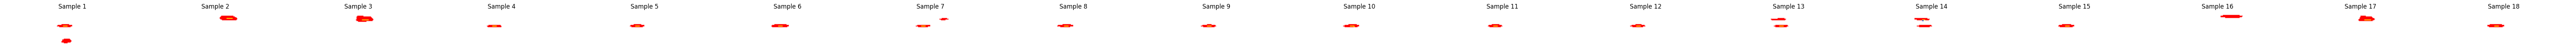

1


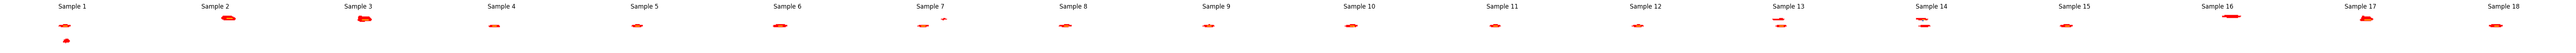

In [7]:
from torch.utils.data import DataLoader, Dataset
test_loader = DataLoader(
    test_loader.dataset,
    batch_size=64,
    shuffle=False
)

visualize_predictions(model, test_loader, num_samples=18)
print(1)
visualize_predictions(model, test_loader, num_samples=18, phase='test2')

In [8]:
# Please write your model code (including the necessary imported modules, such as torch and torch.nn) below to generate a model structure file that can be easily loaded by the grading platform
model_code = """  
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.ndimage import label
def find_largest_connected_component(predictions):
    
    # Set the top 5 rows to zero
    predictions[:, :5, :] = 0
    
    # Set the bottom 5 rows to zero
    predictions[:, -5:, :] = 0
    
    # Set the first 5 columns to zero
    predictions[:, :, :15] = 0
    
    # Set the last 5 columns to zero
    predictions[:, :, -15:] = 0
    # Convert predictions to numpy array
    predictions_np = predictions.cpu().numpy()
    return predictions_np
    # Initialize an array to store the largest component
    # largest_component = np.zeros_like(predictions_np)
    
    # for i in range(predictions_np.shape[0]):  # Iterate over batch
    #     # Label connected components
    #     labeled_array, num_features = label(predictions_np[i])
        
    #     # Find the largest component
    #     if num_features > 0:
    #         largest_component_size = 0
    #         largest_component_label = 0
    #         for label_num in range(1, num_features + 1):
    #             component_size = np.sum(labeled_array == label_num)
    #             if component_size > largest_component_size:
    #                 largest_component_size = component_size
    #                 largest_component_label = label_num
            
    #         # Set the largest component in the output
    #         largest_component[i] = (labeled_array == largest_component_label)
    
    # return torch.tensor(largest_component, dtype=torch.float32).to(predictions.device)
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Encoder
        self.enc_conv1 = self.conv_block(6, 16)
        self.enc_conv2 = self.conv_block(16, 32)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck = self.conv_block(32, 64)
        
        # Decoder
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv1 = self.conv_block(96, 32)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv2 = self.conv_block(48, 16)
        
        # Output layer
        self.out_conv = nn.Conv2d(16, 2, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels, dropout_rate=0.5):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),  # Use LeakyReLU
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)  # Use LeakyReLU
        )
    def dilate_label1_regions(self, predictions):
        # 获取当前预测的label 1 mask [B, H, W]
        pred_mask = torch.argmax(predictions, dim=1)
        
        # 创建非对称膨胀核（5x3大小）
        kernel = torch.zeros((1, 1, 3, 5), device=predictions.device)  # [1,1,H,W]
        kernel[0, 0, 1, :] = 1  # 中心行全1（横向延伸2像素）
        
        # 对每个样本进行处理
        dilated_masks = []
        for i in range(pred_mask.shape[0]):
            mask = pred_mask[i].float().unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
            
            # 应用膨胀（padding=2横向，padding=1纵向）
            dilated = F.conv2d(mask, kernel, padding=(1, 2))  # (padH, padW)
            dilated = (dilated > 0).float()
            dilated_masks.append(dilated.squeeze())
        
        dilated_mask = torch.stack(dilated_masks)  # [B,H,W]
        
        # 更新预测结果
        new_label1_mask = (dilated_mask == 1) & (pred_mask == 0)
        processed_output = predictions.clone()
        processed_output[:, 1][new_label1_mask] = 1.0   # 强制新区域预测为1
        processed_output[:, 0][new_label1_mask] = -1.0  # 抑制背景通道
        
        return processed_output
    def forward(self, x, mode = 'test'):
        padding = (5, 6, 3, 3)  
        x = F.pad(x, padding, mode='constant', value=0).cuda()
        
        # Encoder
        x1 = self.enc_conv1(x)
        x2 = self.pool(x1)
        x2 = self.enc_conv2(x2)
        x3 = self.pool(x2)
        
        # Bottleneck
        x3 = self.bottleneck(x3)
        
        # Decoder
        x4 = self.upsample1(x3)
        x4 = torch.cat([x4, x2], dim=1)  # Skip connection
        x4 = self.dec_conv1(x4)
        
        x5 = self.upsample2(x4)
        x5 = torch.cat([x5, x1], dim=1)  # Skip connection
        x5 = self.dec_conv2(x5)
        # Output layer
        x_out = self.out_conv(x5)
        # Crop the output to the desired size (181, 50)
        x_out = x_out[:, :, :50, :181]
        if mode == 'test':
            predictions = torch.argmax(x_out, dim=1)
            largest_component = find_largest_connected_component(predictions)
            mask = largest_component == 0
            x_out[:, 1, :, :][mask] = float('-inf')
            #visualize_prediction(largest_component)
            #visualize_prediction(predictions)
            #visualize_prediction(torch.argmax(x_out, dim=1))
            kernel_weights = torch.zeros((2, 2, 5, 5), device=x_out.device)  # [out_ch, in_ch, H, W]
        
        # Middle row is 1 for both input and output channels
            kernel_weights[:, :, 2, :] = 1  # Set middle row to 1 for all channels
            kernel_weights[:, :, 1:4, 2] = 1
        # Apply the convolution with padding=2 to maintain spatial dimensions
            x_out = self.process_label1_regions(x_out)
            x_out = self.dilate_label1_regions(x_out)
            return x_out
        if mode == 'test2':
            predictions = torch.argmax(x_out, dim=1)
            largest_component = find_largest_connected_component(predictions)
            mask = largest_component == 0
            x_out[:, 1, :, :][mask] = float('-inf')
            #visualize_prediction(largest_component)
            #visualize_prediction(predictions)
            #visualize_prediction(torch.argmax(x_out, dim=1))
            kernel_weights = torch.zeros((2, 2, 5, 5), device=x_out.device)  # [out_ch, in_ch, H, W]
        
        # Middle row is 1 for both input and output channels
            kernel_weights[:, :, 2, :] = 1  # Set middle row to 1 for all channels
            kernel_weights[:, :, 1:4, 2] = 1
        # Apply the convolution with padding=2 to maintain spatial dimensions
            x_out = self.process_label1_regions(x_out)
            return x_out
        return x_out
    def process_label1_regions(self, predictions, threshold_ratio=0.5):
        # Get binary mask for label 1
        pred_mask = torch.argmax(predictions, dim=1)  # [B, H, W]
        label1_mask = (pred_mask == 1).cpu().numpy()  # Convert to numpy for scipy
        
        processed_output = predictions.clone()
        
        for i in range(predictions.shape[0]):  # Process each sample in batch
            # Label connected components
            labeled_array, num_features = label(label1_mask[i])
            
            if num_features == 0:
                continue  # No label 1 regions
                
            # Calculate bounding box widths for each component
            bbox_widths = []
            for label_num in range(1, num_features + 1):
                rows, cols = np.where(labeled_array == label_num)
                if len(rows) == 0:
                    bbox_widths.append(0)
                    continue
                min_row, max_row = np.min(rows), np.max(rows)
                min_col, max_col = np.min(cols), np.max(cols)
                width = max_col - min_col + 1  # +1 because both ends are inclusive
                bbox_widths.append(width)
            
            max_width = np.max(bbox_widths)
            threshold = max_width * threshold_ratio
            
            # Create mask for narrow regions to remove
            remove_mask = np.zeros_like(label1_mask[i], dtype=bool)
            
            for label_num in range(1, num_features + 1):
                if bbox_widths[label_num - 1] < threshold:
                    remove_mask |= (labeled_array == label_num)
            
            # Set narrow regions to label 0 by setting label 1 channel to -inf
            if remove_mask.any():
                processed_output[i, 1][torch.from_numpy(remove_mask).to(predictions.device)] = float('-inf')
        
        return processed_output
"""
# Write code to file
with open('submission_model.py', 'w',encoding="utf-8") as f:
    f.write(model_code)
print("submission_model.py file has been generated.")

submission_model.py file has been generated.


In [9]:
# This block mainly specifies the submission format of this question.
import zipfile
import os

# Define the files to zip and the zip file name.
files_to_zip = ['submission_model.py', 'submission_dic.pth']
zip_filename = 'submission.zip'

# Create a zip file
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in files_to_zip:
        # Add the file to the zip fil
        zipf.write(file, os.path.basename(file))

print(f'{zip_filename} Created successfully!')

submission.zip Created successfully!


In [10]:
# Save the parameters of the model
torch.save(model.state_dict(), 'submission_dic.pth')
print("submission_dic.pth file has been saved.")

submission_dic.pth file has been saved.
